In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, log_loss
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from imblearn.under_sampling import *
from imblearn.combine import *
from imblearn.over_sampling import *
import lightgbm as lgb
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

sns.set_context("paper")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# San Francisco Crime Classification
- Predict the category of crimes that occurred in the city by the bay

$$ logloss={-\frac{1}{N}}\sum_{i=1}^N\sum_{j=1}^My_{ij}log(p_{ij})$$

## 1. Overview

### 1) Data Shape

In [4]:
df_train = pd.read_csv("./train.csv", parse_dates=['Dates'])
df_test = pd.read_csv("./test.csv", parse_dates=['Dates'])

In [88]:
df_train.shape, df_test.shape

((878049, 9), (884262, 7))

In [84]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB


In [85]:
df_train.describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


In [4]:
df_train.tail()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,"CHECKS, FORGERY (FELONY)",Monday,BAYVIEW,NONE,1800 Block of NEWCOMB AV,-122.394926,37.738212


### 2) column 설명

##### 1. Dates (사건일자)
: timestamp of the crime incident
##### 2. Category (범죄유형 - 종속변수)
: category of the crime incident (only in train.csv). This is the target variable you are going to predict.
##### 3. Descript (범죄 세부정보)
: detailed description of the crime incident (only in train.csv)
##### 4. DayOfWeek (요일)
: the day of the week
##### 5. PdDistrict (관할서)
: name of the Police Department District
##### 6. Resolution (처벌결과)
: how the crime incident was resolved (only in train.csv)
##### 7. Address (사건현장 대략적 주소)
: the approximate street address of the crime incident 
##### 8. X (경도)
:Longitude
##### 9. Y (위도)
: Latitude

In [5]:
df_test.tail()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
884257,884257,2003-01-01 00:01:00,Wednesday,MISSION,2600 Block of BRYANT ST,-122.408983,37.751987
884258,884258,2003-01-01 00:01:00,Wednesday,NORTHERN,1900 Block of WASHINGTON ST,-122.425342,37.792681
884259,884259,2003-01-01 00:01:00,Wednesday,INGLESIDE,5500 Block of MISSION ST,-122.445418,37.712075
884260,884260,2003-01-01 00:01:00,Wednesday,BAYVIEW,1500 Block of HUDSON AV,-122.387394,37.739479
884261,884261,2003-01-01 00:01:00,Wednesday,TARAVAL,1500 Block of SLOAT BL,-122.489714,37.733950


In [6]:
for i in df_train.columns:
    print(i, "\n", df_train[i].unique(), len(df_train[i].unique()))

Dates 
 ['2015-05-13T23:53:00.000000000' '2015-05-13T23:33:00.000000000'
 '2015-05-13T23:30:00.000000000' ... '2003-01-06T00:20:00.000000000'
 '2003-01-06T00:15:00.000000000' '2003-01-06T00:01:00.000000000'] 389257
Category 
 ['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT'] 39
Descript 
 ['WARRANT ARREST' 'TRAFFIC VIOLATION ARREST'
 'GRAND THEFT FROM LOCKED AUTO' 'GRAND THEFT FROM UNLOCKED AUTO'
 'STOLEN AUTOMOBILE' 'PETTY THEFT FROM LOCKED A

DayOfWeek 
 ['Wednesday' 'Tuesday' 'Monday' 'Sunday' 'Saturday' 'Friday' 'Thursday'] 7
PdDistrict 
 ['NORTHERN' 'PARK' 'INGLESIDE' 'BAYVIEW' 'RICHMOND' 'CENTRAL' 'TARAVAL'
 'TENDERLOIN' 'MISSION' 'SOUTHERN'] 10
Resolution 
 ['ARREST, BOOKED' 'NONE' 'ARREST, CITED' 'PSYCHOPATHIC CASE'
 'JUVENILE BOOKED' 'UNFOUNDED' 'EXCEPTIONAL CLEARANCE' 'LOCATED'
 'CLEARED-CONTACT JUVENILE FOR MORE INFO' 'NOT PROSECUTED'
 'JUVENILE DIVERTED' 'COMPLAINANT REFUSES TO PROSECUTE'
 'JUVENILE ADMONISHED' 'JUVENILE CITED'
 'DISTRICT ATTORNEY REFUSES TO PROSECUTE' 'PROSECUTED BY OUTSIDE AGENCY'
 'PROSECUTED FOR LESSER OFFENSE'] 17
Address 
 ['OAK ST / LAGUNA ST' 'VANNESS AV / GREENWICH ST'
 '1500 Block of LOMBARD ST' ... '300 Block of JOHN F KENNEDY DR'
 'FOLSOM ST / ZENO PL' '1000 Block of 22ND AV'] 23228
X 
 [-122.42589168 -122.42436302 -122.42699533 ... -122.48124622 -122.41850208
 -122.39492572] 34243
Y 
 [37.7745986  37.80041432 37.80087263 ... 37.77644744 37.73394539
 37.73821154] 34243


test데이터에 Descript, Resolution column이 없으므로 train에서 Descript, Resolution column 제거 

##### Drop Descript, Resolution in train

In [7]:
df_train.drop(columns=['Descript','Resolution'],inplace=True)

## 2. Feature Extraction
- 시간 : year, month, hour column 추출
- 공간 : street name & street number 추출
- event : 1 추가

In [8]:
df_train['year'] = df_train['Dates'].map(lambda x: x.year)
df_train['month'] = df_train['Dates'].map(lambda x: x.month)
df_train['hour'] = df_train['Dates'].map(lambda x: x.hour)

In [9]:
def street_addr(x):
    street=x.split(' ')
    return (' '.join(street[-2:]))

In [10]:
df_train['addr']=df_train['Address'].apply(lambda x:street_addr(x))
df_train['addr'].tail()

878044    CAPITOL AV
878045       EDNA ST
878046     FOLSOM ST
878047        2ND ST
878048    NEWCOMB AV
Name: addr, dtype: object

In [11]:
df_train['addr'].unique(),len(df_train['addr'].unique()) 

(array(['LAGUNA ST', 'GREENWICH ST', 'LOMBARD ST', ..., 'LAKES DR',
        'WEBB PL', 'ZENO PL'], dtype=object), 2040)

In [12]:
df_train['event'] = 1

### 3. Exploratory data analysis

##### 1) 요일별 범죄발생수

In [13]:
crime_by_dayofweek = df_train[['Category','DayOfWeek','event']].groupby(['Category','DayOfWeek']).count().reset_index()
crime_by_dayofweek_pivot1 = crime_by_dayofweek.pivot(index='Category',columns='DayOfWeek',values='event')
crime_by_dayofweek_pivot1

DayOfWeek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Category,,,,,,,
ARSON,220.0,228.0,220.0,211.0,199.0,235.0,200.0
ASSAULT,11160.0,10560.0,11995.0,12082.0,10246.0,10280.0,10553.0
BAD CHECKS,62.0,66.0,45.0,20.0,66.0,76.0,71.0
BRIBERY,49.0,41.0,42.0,41.0,39.0,37.0,40.0
BURGLARY,6327.0,5262.0,4754.0,4231.0,5350.0,5374.0,5457.0
DISORDERLY CONDUCT,541.0,608.0,624.0,586.0,644.0,657.0,660.0
DRIVING UNDER THE INFLUENCE,352.0,263.0,457.0,442.0,282.0,251.0,221.0
DRUG/NARCOTIC,7420.0,7823.0,6390.0,6143.0,8454.0,8474.0,9267.0
DRUNKENNESS,622.0,513.0,833.0,813.0,496.0,461.0,542.0


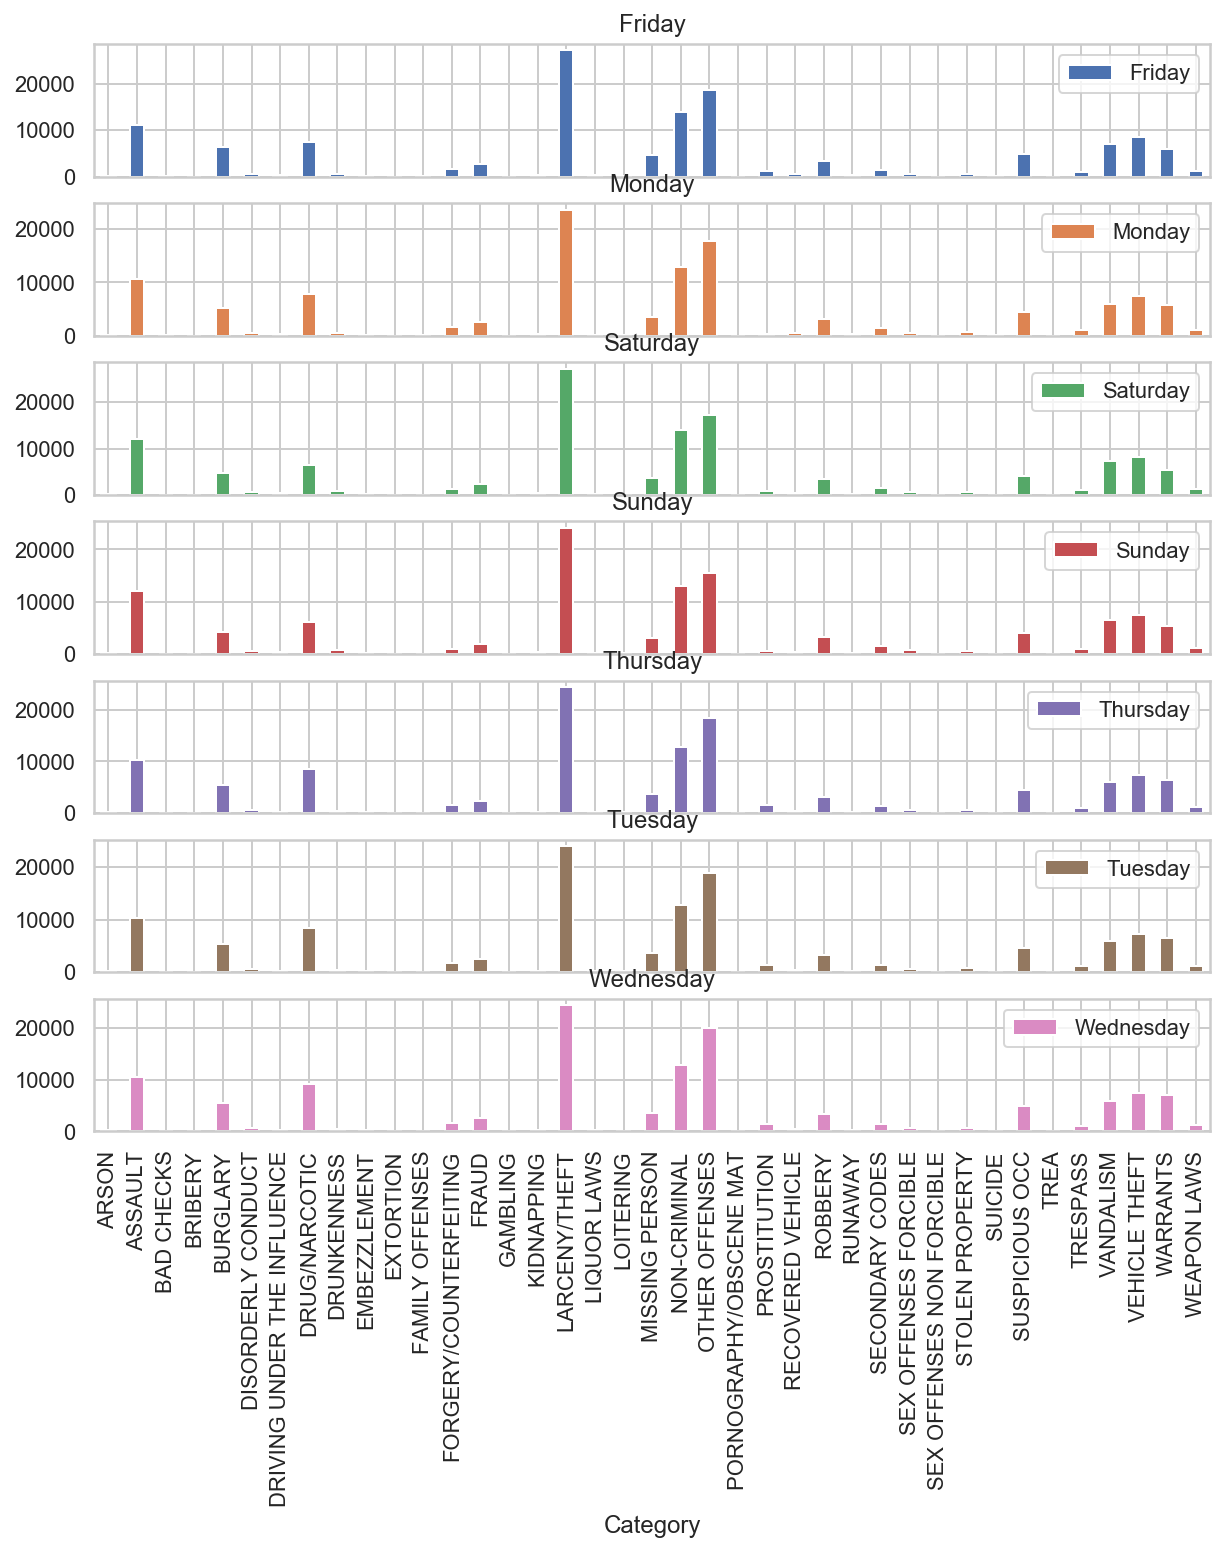

In [14]:
crime_by_dayofweek_pivot1.plot(kind='bar',subplots=True, figsize=(10,10))
plt.show()

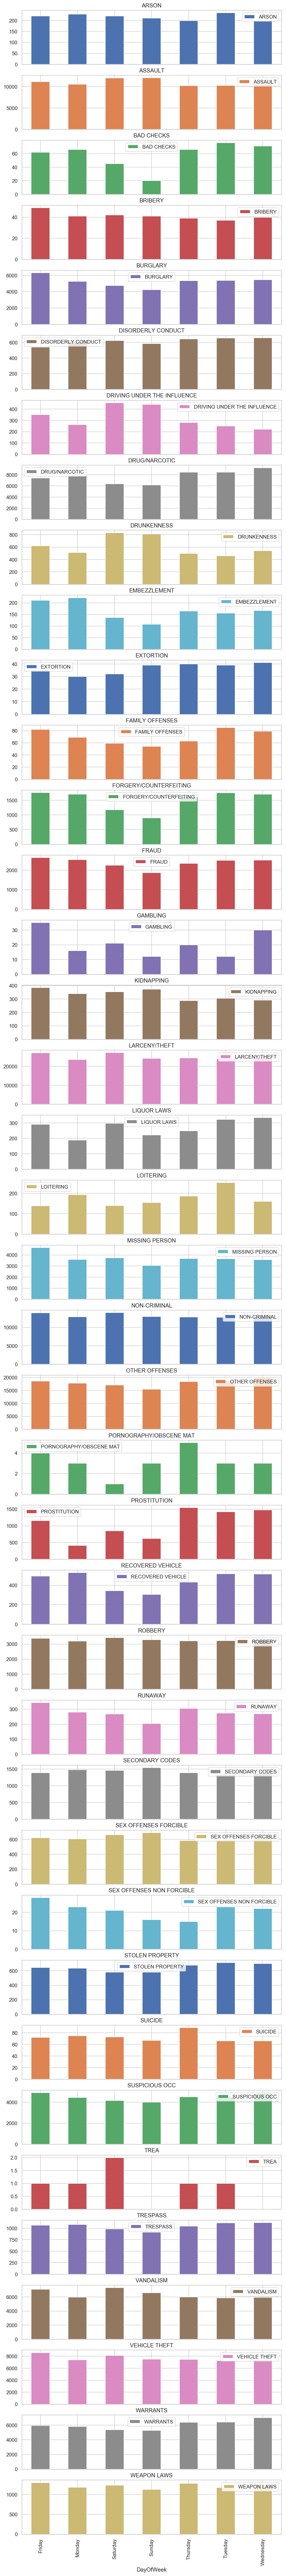

In [16]:
crime_by_dayofweek_pivot2 = crime_by_dayofweek.pivot(index='DayOfWeek',columns='Category',values='event')
crime_by_dayofweek_pivot2.plot(kind='bar', subplots=True, figsize=(10,100),sharex=True)
plt.show()

모든 범죄에서 요일별로 범죄발생수에 차이를 보인다. 

##### 2) 연도별 범죄발생수

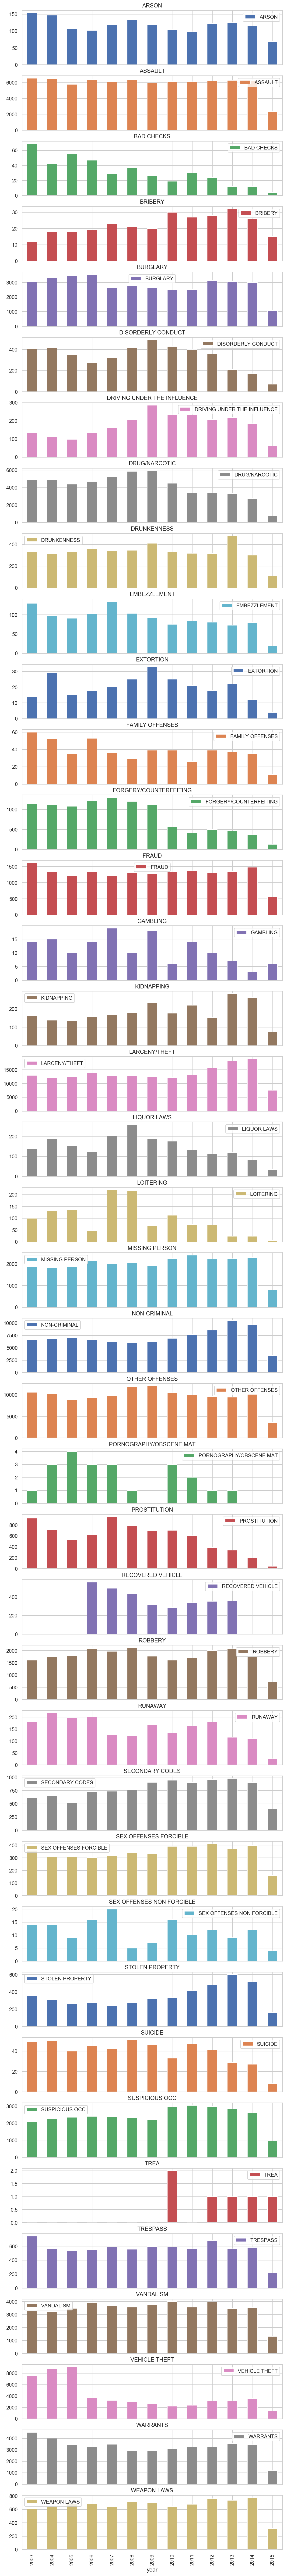

In [18]:
crime_by_year = df_train[['Category','year','event']].groupby(['Category','year']).count().reset_index()
crime_by_year_pivot = crime_by_year.pivot(index='year',columns='Category',values='event')
crime_by_year_pivot.plot(kind='bar', subplots=True, figsize=(10,100))
plt.show()

범죄별로 연도별 범죄발생수에 차이를 보인다.

##### 3) 시간대별 범죄발생수

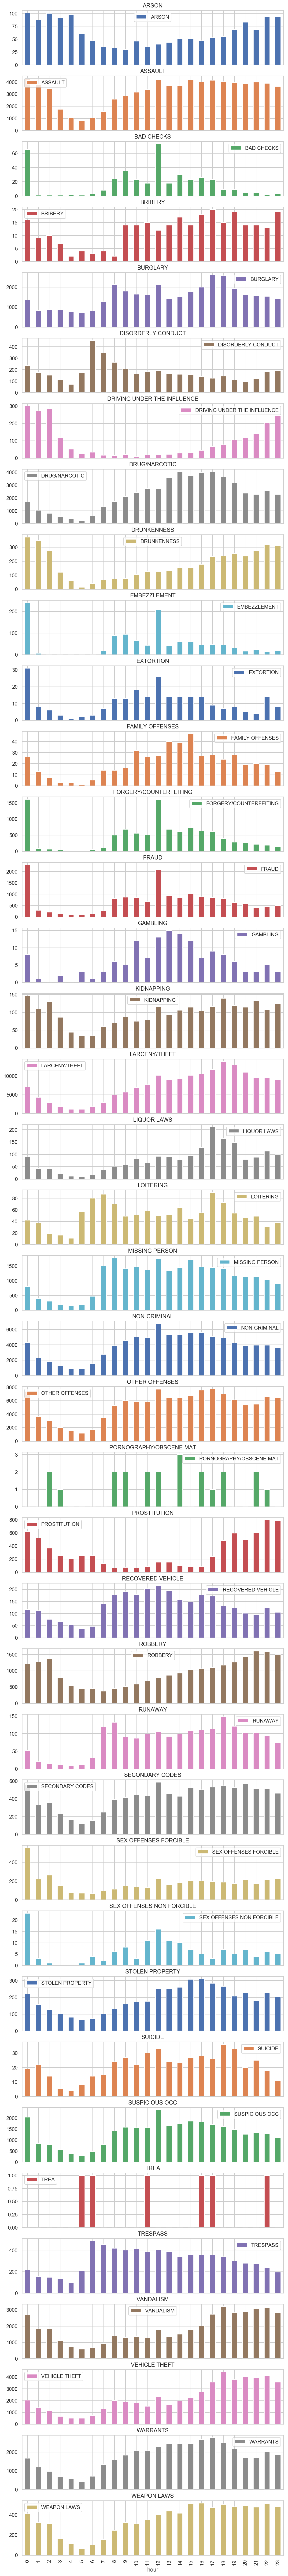

In [19]:
crime_by_hour = df_train[['Category','hour','event']].groupby(['Category','hour']).count().reset_index()
crime_by_hour_pivot = crime_by_hour.pivot(index='hour',columns='Category',values='event')
crime_by_hour_pivot.plot(kind='bar', subplots=True, figsize=(10,100))
plt.show()

범죄별로 시간대별 범죄발생수에 차이를 보인다.

##### 4) 월별 범죄발생수

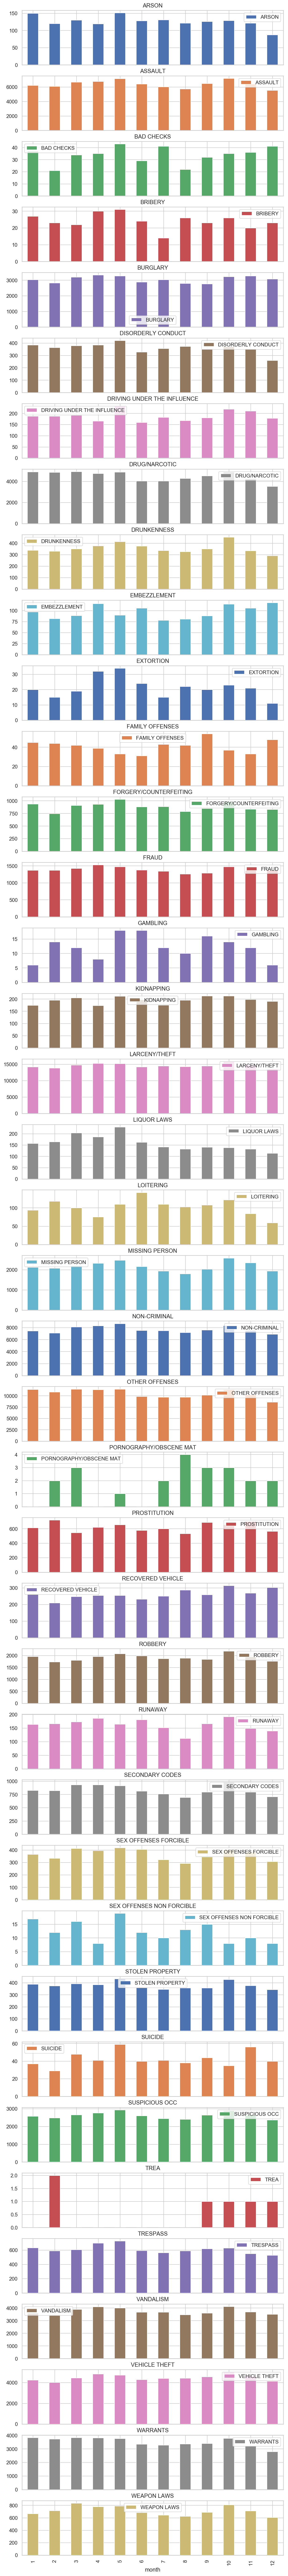

In [21]:
crime_by_month = df_train[['Category','month','event']].groupby(['Category','month']).count().reset_index()
crime_by_month_pivot = crime_by_month.pivot(index='month',columns='Category',values='event')
crime_by_month_pivot.plot(kind='bar', subplots=True, figsize=(10,100))
plt.show()

범죄별로 월별 범죄발생수에 차이를 보인다.

##### 5) 범죄별 범죄발생위치 

In [22]:
crime_address = df_train[['Category','Address','event']].groupby(['Category','Address']).sum().reset_index()
crime_address.sort_values(by=['Category','event'], ascending=False, inplace=True)

In [23]:
len(crime_address[crime_address.Category == "LARCENY/THEFT"]), crime_address[crime_address.Category == "LARCENY/THEFT"]

(17535,             Category                                Address  event
 55937  LARCENY/THEFT                 800 Block of BRYANT ST   6144
 56053  LARCENY/THEFT                 800 Block of MARKET ST   3256
 47706  LARCENY/THEFT               100 Block of OFARRELL ST   1098
 53263  LARCENY/THEFT                  3200 Block of 20TH AV   1015
 55725  LARCENY/THEFT                 700 Block of MARKET ST    863
 51074  LARCENY/THEFT                2000 Block of MARKET ST    753
 46717  LARCENY/THEFT                   0 Block of PHELAN AV    697
 54823  LARCENY/THEFT           500 Block of JOHNFKENNEDY DR    690
 47750  LARCENY/THEFT                 100 Block of POWELL ST    666
 46739  LARCENY/THEFT                   0 Block of POWELL ST    634
 46667  LARCENY/THEFT                 0 Block of OFARRELL ST    624
 56324  LARCENY/THEFT                 900 Block of MARKET ST    611
 51568  LARCENY/THEFT                  2300 Block of 16TH ST    511
 48878  LARCENY/THEFT               1300 

#### 각 범죄별로 가장 많이 발생한 위치 5군데를 뽑아보자

In [25]:
for crime in crime_address.Category.unique():
    result = crime_address[crime_address.Category == crime]
    print("Crime: ",crime,"\t", "Address count: ",len(result),"\n" ,result.head(),"\n")

Crime:  WEAPON LAWS 	 Address count:  3565 
            Category                    Address  event
169473  WEAPON LAWS     800 Block of BRYANT ST    156
168393  WEAPON LAWS   2000 Block of MISSION ST     77
167176  WEAPON LAWS          0 Block of 6TH ST     44
167431  WEAPON LAWS         0 Block of TURK ST     42
169555  WEAPON LAWS  900 Block of ELLSWORTH ST     37 

Crime:  WARRANTS 	 Address count:  7836 
         Category                   Address  event
163882  WARRANTS    800 Block of BRYANT ST   1719
161754  WARRANTS  2000 Block of MISSION ST    567
163946  WARRANTS    800 Block of MARKET ST    477
159860  WARRANTS        0 Block of TURK ST    392
160343  WARRANTS  1000 Block of POTRERO AV    322 

Crime:  VEHICLE THEFT 	 Address count:  14588 
              Category                     Address  event
147669  VEHICLE THEFT  1500 Block of BAY SHORE BL    162
150974  VEHICLE THEFT    300 Block of OFARRELL ST    145
153595  VEHICLE THEFT      800 Block of BRYANT ST    128
152065  V

Crime:  BURGLARY 	 Address count:  7852 
        Category                       Address  event
20187  BURGLARY        800 Block of BRYANT ST    384
20279  BURGLARY        800 Block of MARKET ST    380
16583  BURGLARY  200 Block of INTERSTATE80 HY    128
14475  BURGLARY      100 Block of OFARRELL ST    127
13662  BURGLARY        0 Block of OFARRELL ST    121 

Crime:  BRIBERY 	 Address count:  255 
       Category                         Address  event
12935  BRIBERY          800 Block of BRYANT ST     12
12825  BRIBERY        2000 Block of MISSION ST      5
12728  BRIBERY               0 Block of 6TH ST      3
12914  BRIBERY  500 Block of SOUTH VAN NESS AV      3
12730  BRIBERY         0 Block of BROOKDALE AV      2 

Crime:  BAD CHECKS 	 Address count:  333 
          Category                    Address  event
12689  BAD CHECKS     800 Block of BRYANT ST     12
12456  BAD CHECKS    1100 Block of MARKET ST      7
12417  BAD CHECKS         0 Block of POST ST      5
12486  BAD CHECKS  15

- Street별로 카테고리화해본다.
- PdDistrict별로 범죄발생유형이 다를 것이라고 가정.

In [26]:
df_train['addr'].nunique()

2040

In [27]:
crime_by_PdDistrict = df_train[['PdDistrict','Category','event','X','Y']].groupby(['PdDistrict','Category']).agg({'X':'first', 'Y':'first','event':'sum'}).reset_index()
crime_by_PdDistrict

,PdDistrict,Category,X,Y,event
0,BAYVIEW,ARSON,-122.401152,37.738363,393
1,BAYVIEW,ASSAULT,-122.398696,37.754746,9857
2,BAYVIEW,BAD CHECKS,-122.389864,37.737586,34
3,BAYVIEW,BRIBERY,-122.405610,37.732439,56
4,BAYVIEW,BURGLARY,-122.417938,37.726605,3930
5,BAYVIEW,DISORDERLY CONDUCT,-122.398004,37.719033,219
6,BAYVIEW,DRIVING UNDER THE INFLUENCE,-122.398075,37.730039,179
7,BAYVIEW,DRUG/NARCOTIC,-122.381838,37.731104,4498
8,BAYVIEW,DRUNKENNESS,-122.390965,37.734429,243
9,BAYVIEW,EMBEZZLEMENT,-122.391515,37.738038,100


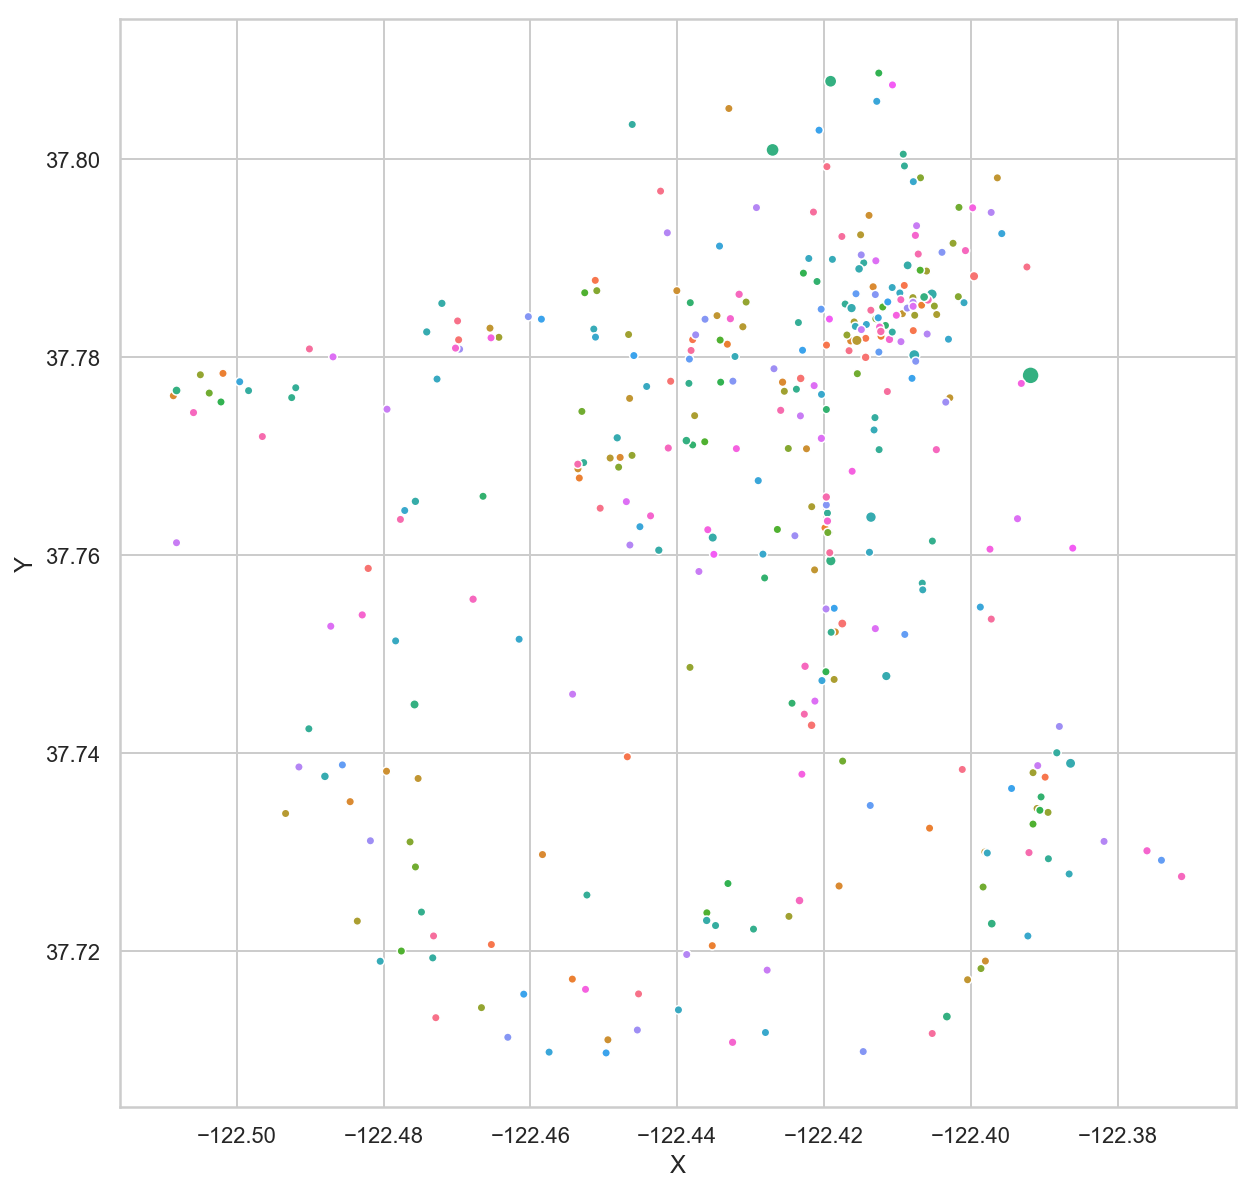

In [31]:
plt.figure(figsize=(10,10))
area = np.pi * crime_by_PdDistrict['event'] ** 2
sns.scatterplot(x='X',y='Y', hue='Category', size=area, data=crime_by_PdDistrict, legend=False)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


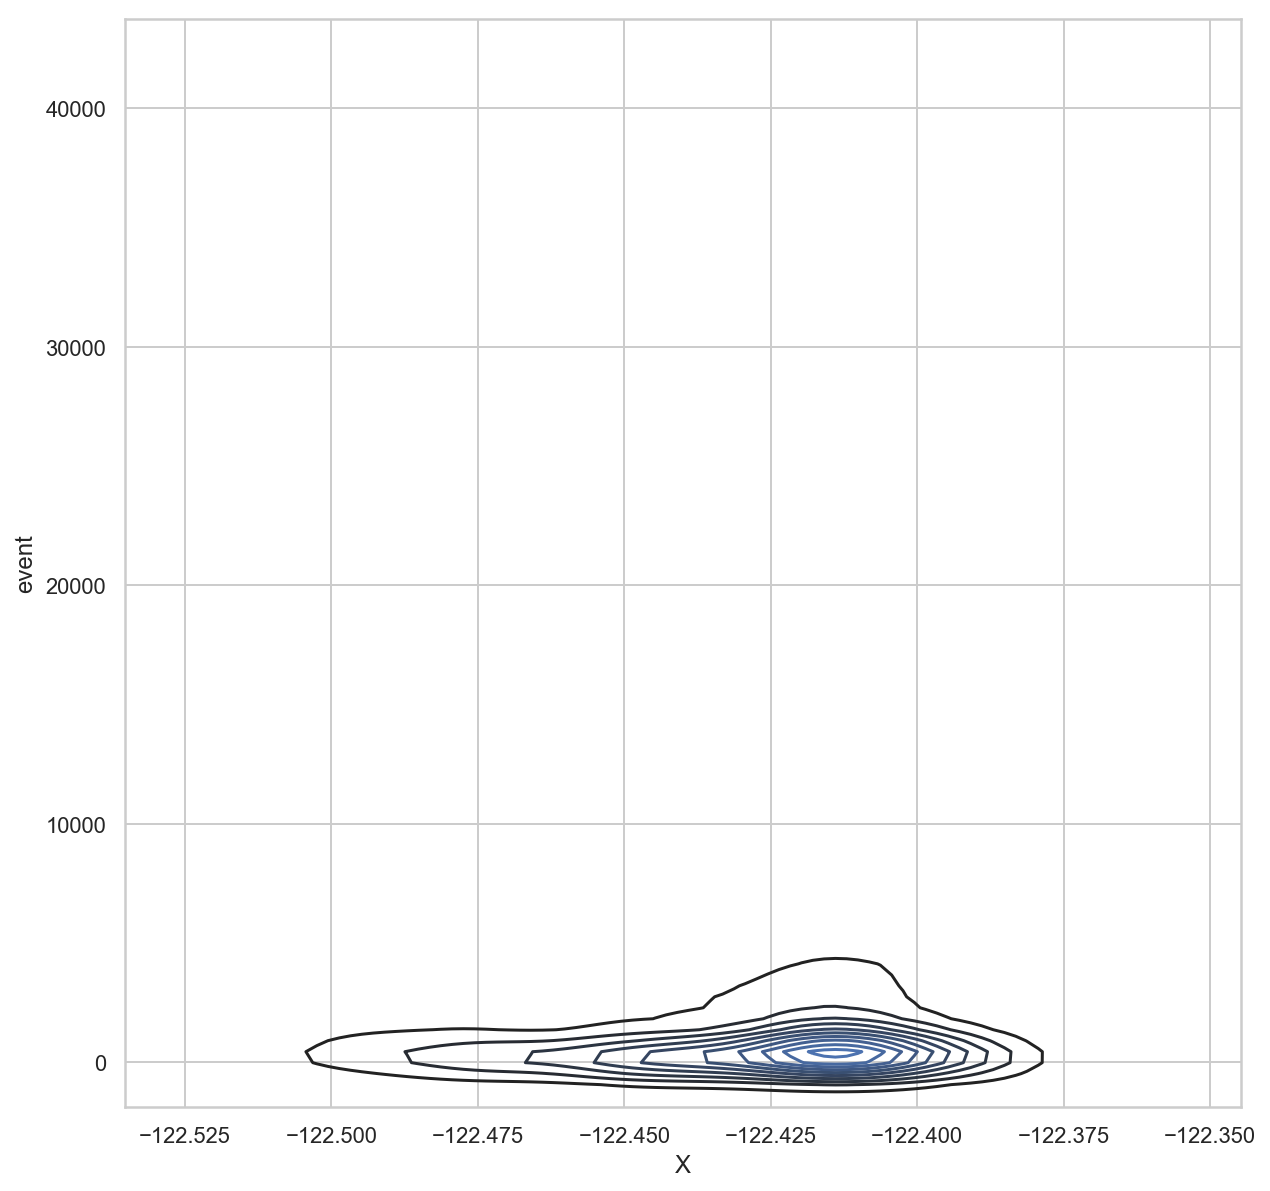

In [32]:
plt.figure(figsize=(10,10))
sns.kdeplot(crime_by_PdDistrict['X'], crime_by_PdDistrict['event'])
plt.show()

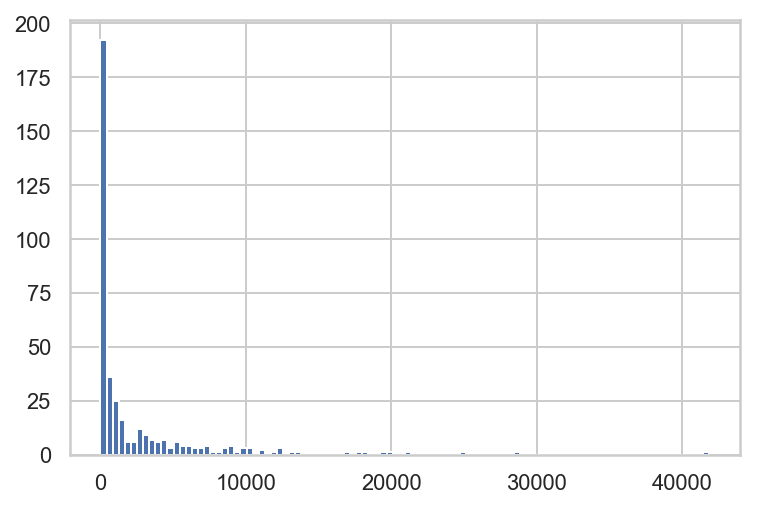

In [33]:
plt.hist(crime_by_PdDistrict['event'], bins=100)
plt.show()

좀 더 develope시켜야 함.

### 4. Modeling
- Done
    - Over-Sampling
    - Logistic Regression
    - Bernoulli NB
    - RandomForest
    - Gradient Boosting(LightGBM)
- Developing
    - SVM
    - keras

##### 0) Over-Sampling

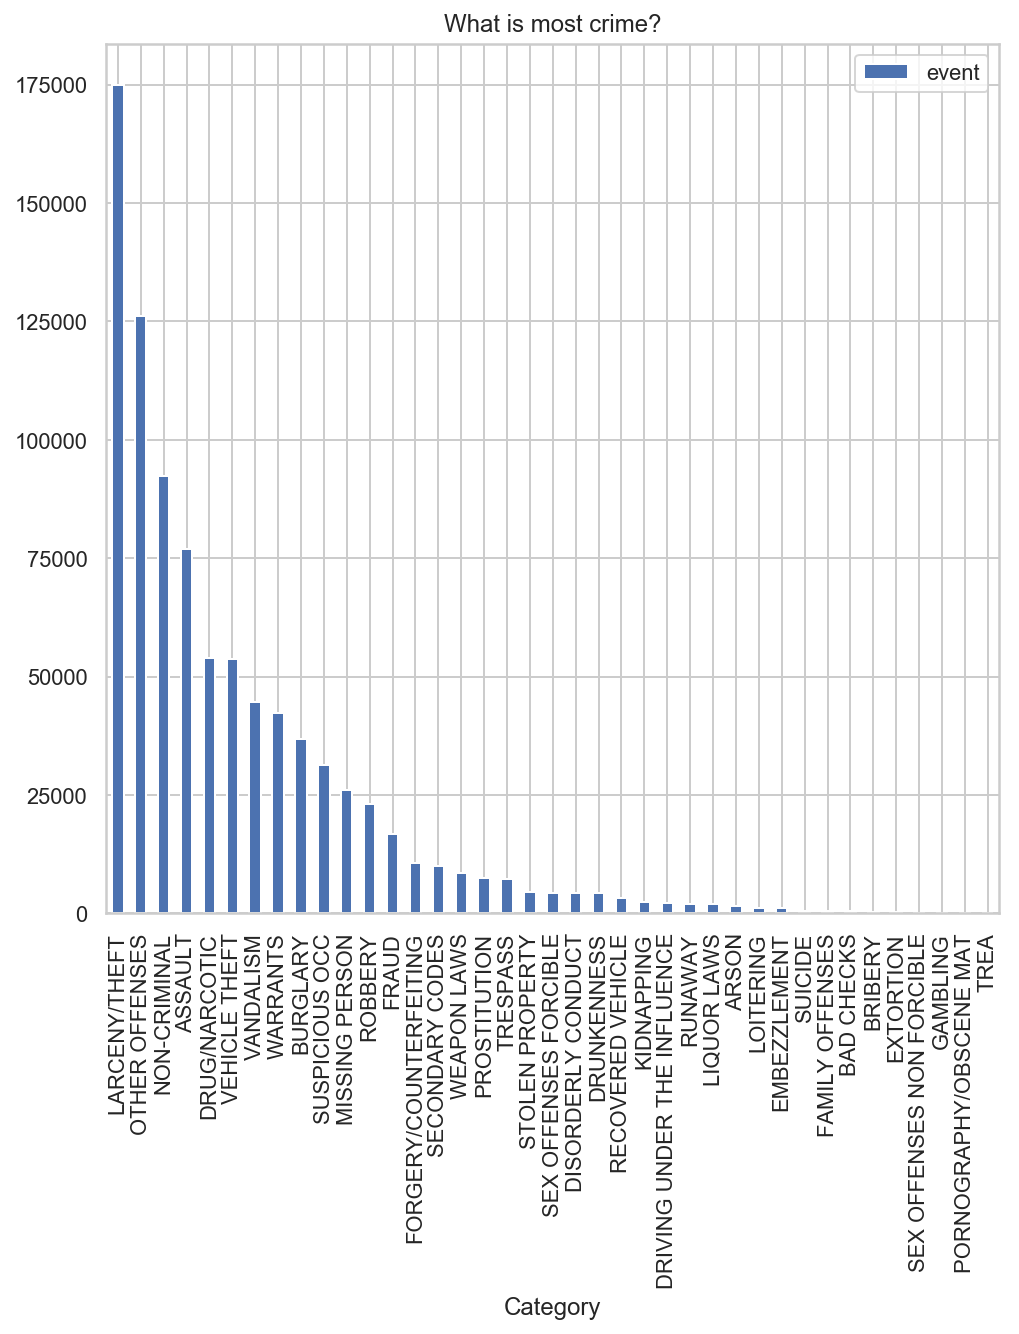

In [34]:
most_crime = df_train[['Category','event']].groupby("Category").sum().reset_index().sort_values(by="event", ascending=False)
most_crime.plot(kind='bar', x='Category', title="What is most crime?", figsize=(8,8))

- 종속변수 class별로 샘플수가 차이가 크다
    - Mix-Sampling 진행

In [50]:
le = LabelEncoder().fit(df_train.Category)

df_train.Category = le.transform(df_train.Category)
df_train.tail()

x_DayOfWeek = pd.get_dummies(df_train.DayOfWeek)
x_PdDistrict = pd.get_dummies(df_train.PdDistrict)
x_X = pd.DataFrame(df_train.X, columns=['lon'])
x_Y = pd.DataFrame(df_train.Y, columns=['lat'])
x_month = pd.get_dummies(df_train.month, prefix="", prefix_sep='month_')
x_hour = pd.get_dummies(df_train.hour, prefix="", prefix_sep='hour_')

x = pd.concat([x_DayOfWeek, x_PdDistrict, x_month, x_hour], axis=1)
y = pd.DataFrame(df_train.Category, columns=['Category'])

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

##### 1) Logistic Regression

In [67]:
model_logi = OneVsRestClassifier(LogisticRegression()).fit(x_train,y_train)

In [44]:
log_loss(y_test, model_logi.predict_proba(x_test))

2.5778464730024089

<img style="float:left;transform: rotate(0deg); width:1200px" src="score_logi.png" />

##### 2) Bernoulli Naive Bayes 

In [66]:
model_bern = OneVsRestClassifier(BernoulliNB()).fit(x_train,y_train)

In [41]:
log_loss(y_train, model_bern.predict_proba(x_train))

2.5782026660348896

<img style="float:left;transform: rotate(0deg); width:1200px" src="bernoulliNB_score.PNG" />

In [89]:
df_train = pd.read_csv("./Kaggle_project_2/datasets/train.csv", parse_dates=['Dates'])
df_test = pd.read_csv("./Kaggle_project_2/datasets/test.csv", parse_dates=['Dates'])

In [90]:
df_train = pd.DataFrame(df_train)
df_train = df_train[df_train["Y"] < 90]
df_train["X"] = round(df_train["X"], 3)
df_train["Y"] = round(df_train["Y"], 3)

df_train["Dates"] = pd.to_datetime(df_train["Dates"])
df_test["Dates"] = pd.to_datetime(df_test["Dates"])

# 시간 분할
df_train["Hour"] = df_train["Dates"].apply(lambda x: x.hour)
df_train["Month"] = df_train["Dates"].apply(lambda x: x.month)
df_train["Year"] = df_train["Dates"].apply(lambda x: x.year)
df_train["DtDate"] = df_train["Dates"].dt.date
df_train["Day"] = df_train["Dates"].dt.weekday
# 주소 압축
df_train["Street"] = df_train["Address"].apply(lambda x: " ".join(x.split()[-2:]))

In [91]:
le_t1 = preprocessing.LabelEncoder()
le_t1.fit(df_train["Category"])
df_train["Category"] = le_t1.transform(df_train["Category"])

le_t2 = preprocessing.LabelEncoder()
le_t2.fit(df_train["PdDistrict"])
df_train["PdDistrict"] = le_t2.transform(df_train["PdDistrict"])

le_t3 = preprocessing.LabelEncoder()
le_t3.fit(df_train["Street"])
df_train["Street"] = le_t3.transform(df_train["Street"])

##### 3) RandomForest

In [80]:
drop_list = [
    "Dates", "Category", "Descript", "Resolution", "DtDate","Address", "DayOfWeek",
]
X = df_train.drop(drop_list, axis=1)
y = df_train["Category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# model train & fit
tree1 = RandomForestClassifier(criterion="entropy", max_depth=13, n_jobs=4).fit(X_train, y_train)
y_proba = tree1.predict_proba(X_test)
y_predict = tree1.predict(X_test)
y_dummies = pd.get_dummies(y_test)

print(classification_report(y_test, y_predict))
print(log_loss(y_dummies, y_proba))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00       440
          1       0.20      0.07      0.11     23172
          2       0.00      0.00      0.00       117
          3       0.00      0.00      0.00        96
          4       0.16      0.00      0.01     10858
          5       0.14      0.02      0.03      1252
          6       0.00      0.00      0.00       676
          7       0.32      0.40      0.36     16253
          8       0.00      0.00      0.00      1309
          9       0.00      0.00      0.00       360
         10       0.00      0.00      0.00        85
         11       0.00      0.00      0.00       151
         12       0.16      0.00      0.00      3200
         13       0.15      0.00      0.00      4933
         14       0.00      0.00      0.00        35
         15       0.00      0.00      0.00       687
         16       0.29      0.78      0.42     52427
         17       0.00      0.00      0.00   

<img style="float:left;transform: rotate(0deg); width:1200px" src="random_forest_score.png" />

##### 4) LightGBM

In [ ]:
ignorings = ["Category", "Dates", "Descript", "DayOfWeek", "Resolution", "Address", "DtDate"]

drop_list = ["Dates", "Category", "Descript", "Resolution", "DtDate", "Address", "DayOfWeek"]
X, y = df_train.drop(drop_list, axis=1), df_train["Category"]
len_y = 0

while len_y != 39:
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    len_y = len(set(y_test))


col_names = ["Hour", "X", "Y", "Month", "Year", "Day", "PdDistrict", "Street"]
X_train = pd.DataFrame(X_train, columns=col_names)


categories = ["Hour", "Month", "Year", "Day", "PdDistrict", "Street"]
d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categories, free_raw_data=False)


params = {}
params["objective"] = "multiclass"
params["metric"] = 'multi_logloss'
params["num_class"] = 39
params["device"] = "cpu"
params["num_leaves"] = 100
params["num_threads"] = 4


clf = lgb.train(params, d_train, 100, verbose_eval=True)
y_prediction = clf.predict(X_test)


y_classified = [np.argmax(line) for line in y_prediction]
print(classification_report(y_test, y_classified))
print(log_loss(pd.get_dummies(y_test), y_prediction))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


<img style="float:left;transform: rotate(0deg); width:1200px" src="score_lgboost.PNG" />

752 / 2335

### 5. Develop 사항
- accuracy, recall-rate 둘 다 낮다.
- 위치정보에 대한 Feature engineering에 대한 아이디어가 더 필요.